In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load dataset
train_data = pd.read_csv("../data/train.csv")
test_data = pd.read_csv("../data/test.csv")

In [3]:
# Display first few rows
print(train_data.head())


   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [ ]:
# Summary statistics
print(train_data.describe(include="all"))


        PassengerId    Survived      Pclass                     Name   Sex  \
count    891.000000  891.000000  891.000000                      891   891   
unique          NaN         NaN         NaN                      891     2   
top             NaN         NaN         NaN  Braund, Mr. Owen Harris  male   
freq            NaN         NaN         NaN                        1   577   
mean     446.000000    0.383838    2.308642                      NaN   NaN   
std      257.353842    0.486592    0.836071                      NaN   NaN   
min        1.000000    0.000000    1.000000                      NaN   NaN   
25%      223.500000    0.000000    2.000000                      NaN   NaN   
50%      446.000000    0.000000    3.000000                      NaN   NaN   
75%      668.500000    1.000000    3.000000                      NaN   NaN   
max      891.000000    1.000000    3.000000                      NaN   NaN   

               Age       SibSp       Parch  Ticket        Fare 

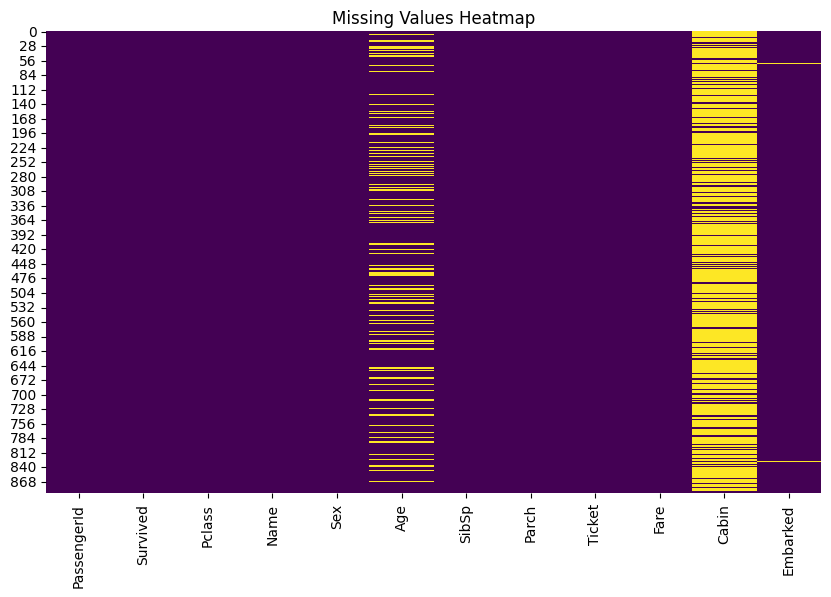

In [5]:
# Check missing values
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

In [6]:
# Check feature correlation with Survived:
# print(train_data.dtypes)
# Select only numeric columns
numeric_data = train_data.select_dtypes(include=[np.number])

print(numeric_data)



     PassengerId  Survived  Pclass   Age  SibSp  Parch     Fare
0              1         0       3  22.0      1      0   7.2500
1              2         1       1  38.0      1      0  71.2833
2              3         1       3  26.0      0      0   7.9250
3              4         1       1  35.0      1      0  53.1000
4              5         0       3  35.0      0      0   8.0500
..           ...       ...     ...   ...    ...    ...      ...
886          887         0       2  27.0      0      0  13.0000
887          888         1       1  19.0      0      0  30.0000
888          889         0       3   NaN      1      2  23.4500
889          890         1       1  26.0      0      0  30.0000
890          891         0       3  32.0      0      0   7.7500

[891 rows x 7 columns]


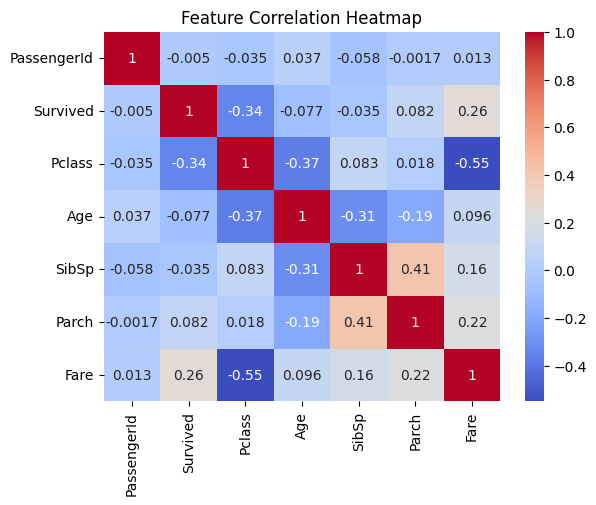

In [7]:
corr = numeric_data.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()

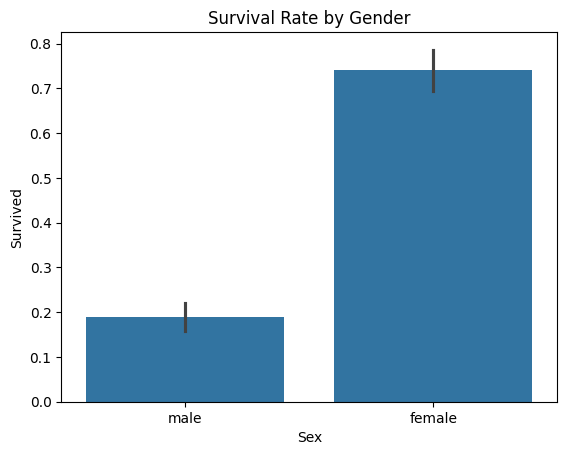

In [8]:
sns.barplot(x="Sex", y="Survived", data=train_data)
plt.title("Survival Rate by Gender")
plt.show()


In [9]:
# Define features and target variable
X = train_data.drop(["Survived", "PassengerId", "Name", "Ticket", "Cabin"], axis=1)
y = train_data["Survived"]

In [10]:
# For test data, drop PassengerId and other non-useful columns
X_test = test_data.drop(["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

In [11]:

# Ensure we select only numeric columns before applying median()
numeric_cols = X.select_dtypes(include=['number']).columns
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

X_test[numeric_cols] = X_test[numeric_cols].fillna(X_test[numeric_cols].median())


In [12]:
# lect categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Fill missing values in categorical columns using the most frequent value (mode)
for col in categorical_cols:
    X[col].fillna(X[col].mode()[0], inplace=True)
    X_test[col].fillna(X_test[col].mode()[0], inplace=True)

In [13]:
# One-hot encode categorical variables
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=categorical_cols, drop_first=True)

# Ensure the test set has the same columns as the train set
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0  # Add missing columns with zero values

# Reorder columns to match X_train
X_test = X_test[X.columns]


In [16]:
from sklearn.model_selection import train_test_split


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to confirm
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")


X_train shape: (712, 8)
X_val shape: (179, 8)
y_train shape: (712,)
y_val shape: (179,)


In [20]:
from sklearn.preprocessing import StandardScaler


In [21]:
scaler = StandardScaler()

# Scale only numerical columns
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols] = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])  # Scale test set with the same scaler


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import joblib


In [23]:
def evaluate_model(model, X_val, y_val):
    """
    Evaluates a trained model using accuracy, precision, recall, and F1-score.
    """
    y_pred = model.predict(X_val)
    if hasattr(model, "predict_proba"):  # Convert probabilities to binary for sklearn models
        y_pred = (y_pred > 0.5).astype(int)

    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"Precision: {precision_score(y_val, y_pred):.4f}")
    print(f"Recall: {recall_score(y_val, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_val, y_pred):.4f}")


In [31]:
import os

In [39]:
def train_logistic_regression(X_train, y_train, X_val, y_val):
    # Train the Logistic Regression model
    log_reg = LogisticRegression(max_iter=1000)
    log_reg.fit(X_train, y_train)

    # Save the model
    # # Ensure the models/ directory exists
    # os.makedirs("models", exist_ok=True)

      # Save the model
    joblib.dump(log_reg, "../models/logistic_regression.pkl")
    
    print("\nLogistic Regression Results:")
    evaluate_model(log_reg, X_val, y_val)


In [40]:
# caliing the fuciton for trainig
train_logistic_regression(X_train, y_train, X_val, y_val)


Logistic Regression Results:
Accuracy: 0.8101
Precision: 0.7857
Recall: 0.7432
F1 Score: 0.7639


In [37]:
import os
print(os.path.exists("models/logistic_regression.pkl"))  # Should print True if saved



True


In [38]:
log_reg_loaded = joblib.load("models/logistic_regression.pkl")
print("Model loaded successfully:", log_reg_loaded)


Model loaded successfully: LogisticRegression(max_iter=1000)


In [43]:
#for random forest
def train_random_forest(X_train, y_train, X_val, y_val):
    # Train the Random Forest model
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)

    # Save the model
    joblib.dump(rf, "../models/random_forest.pkl")
    print("\nRandom Forest Results:")
    evaluate_model(rf, X_val, y_val)


In [44]:
#fior the random forest
train_random_forest(X_train, y_train, X_val, y_val)


Random Forest Results:
Accuracy: 0.8212
Precision: 0.8000
Recall: 0.7568
F1 Score: 0.7778


In [45]:
#for the neural network
from tensorflow.keras import layers, models


In [49]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model_neural_network(model, X_val, y_val):
    """
    Evaluates a trained neural network model using accuracy, precision, recall, and F1-score.
    For multi-class classification, assumes the model outputs probabilities.
    """
    # Make predictions (probabilities)
    y_pred_proba = model.predict(X_val)
    
    # Convert probabilities to class labels (for multi-class classification, use argmax)
    y_pred = np.argmax(y_pred_proba, axis=1)

    # Print classification metrics
    print(f"Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"Precision: {precision_score(y_val, y_pred, average='weighted'):.4f}")
    print(f"Recall: {recall_score(y_val, y_pred, average='weighted'):.4f}")
    print(f"F1 Score: {f1_score(y_val, y_pred, average='weighted'):.4f}")


In [52]:
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

def train_neural_network(X_train, y_train, X_val, y_val):
    # Build the Neural Network model
    model = Sequential([
        # Input layer
        Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.2),  # Dropout layer to prevent overfitting
        # Hidden layer
        Dense(64, activation='relu'),
        Dropout(0.2),
        # Output layer (adjust the number of neurons as per the number of classes)
        Dense(10, activation='softmax')
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))
    
    # Save the model
    model.save('../models/neural_network.h5')
    print("\nNeural Network Results:")
    evaluate_model_neural_network(model, X_val, y_val)



In [53]:
train_neural_network(X_train, y_train, X_val, y_val)


Epoch 1/10


c:\Users\Acer\anaconda3\envs\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.3660 - loss: 2.0693 - val_accuracy: 0.6872 - val_loss: 1.3094
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7058 - loss: 1.1346 - val_accuracy: 0.7374 - val_loss: 0.6523
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7192 - loss: 0.6638 - val_accuracy: 0.7486 - val_loss: 0.5009
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7564 - loss: 0.5350 - val_accuracy: 0.7989 - val_loss: 0.4530
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8024 - loss: 0.5070 - val_accuracy: 0.8380 - val_loss: 0.4255
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8014 - loss: 0.4875 - val_accuracy: 0.8324 - val_loss: 0.4138
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8163 - loss: 0.4632 - val_accuracy: 0.8380 - val_loss: 0.4095
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7971 - loss: 0.4679 - val_accuracy: 0.8268 - val_loss: 0.4147
Ep


Neural Network Results:


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.8436
Precision: 0.8506
Recall: 0.8436
F1 Score: 0.8396


In [ ]:
#hyper paramter tunning
